In [1]:
# Import Libraries
import pandas as pd
import numpy as np

# Read in Data
dat = pd.read_csv('breast_cancer_data.csv')
dat['diagnosis_numeric'] = np.where(dat['diagnosis']=='M', 1, 0)
dat.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_numeric
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [2]:
# T-Test and Effect Size Analysis

# Libraries
from numpy import mean
from numpy import var
from math import sqrt
from scipy.stats import ttest_ind

# Function To Calculate Effect Size
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = mean(d1), mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

# Compare Attribute Information between Malignant and Benign Tumors
predictors= dat.columns[2:32]
data = []
cat1 = dat[dat['diagnosis']=='M']
cat2 = dat[dat['diagnosis']=='B']

for predictor in predictors:
    # Table 
    means = round(dat.groupby(['diagnosis'])[predictor].mean(),4) 
    malignant_tumors = cat1[predictor].copy().dropna()
    benign_tumors = cat2[predictor].copy().dropna()
    mean_comparison_results = ttest_ind(malignant_tumors, benign_tumors)
    t_val, p_val, cohen_val = round(mean_comparison_results[0],3), round(mean_comparison_results[1],3), round(cohend(malignant_tumors, benign_tumors), 3)
    data.append((predictor,
                 means[1], means[0],
                 t_val, p_val, cohen_val))    

# Convert to Dataframe
summary_statistics = pd.DataFrame(data, columns=['Predicting Variable', 'Average - Malignant Tumors', 'Average - Benign Tumors', 
                                                 'T value', 'P Value', 'Cohen\'s D'])
summary_statistics.sort_values(by=['Cohen\'s D'], inplace = True, ascending = False)
summary_statistics.to_csv(r'basic_statistics.csv', index=False)
summary_statistics.head()

,Predicting Variable,Average - Malignant Tumors,Average - Benign Tumors,T value,P Value,Cohen's D
27,concave points_worst,0.1822,0.0744,31.055,0.0,2.693
22,perimeter_worst,141.3703,87.0059,29.966,0.0,2.598
7,concave points_mean,0.0880,0.0257,29.354,0.0,2.545
20,radius_worst,21.1348,13.3798,29.339,0.0,2.544
2,perimeter_mean,115.3654,78.0754,26.405,0.0,2.290


In [3]:
# Basic Classification Method using concave points_worst as sole predictor
from sklearn.metrics import accuracy_score
min_val = np.min(dat['concave points_worst'])
max_val = np.max(dat['concave points_worst'])
accuracy_results = []
vals_to_test = np.linspace(min_val, max_val, num = 100)
for val in vals_to_test:
    predicted_vals = np.where(dat['concave points_worst']>=val, 1, 0)
    accuracy_results.append(accuracy_score(dat['diagnosis_numeric'], predicted_vals))
max_accuracy = np.max(accuracy_results)
print('Maximum Accuracy: ' + str(round(max_accuracy*100,2)) + '%')
index = accuracy_results.index(max_accuracy)
print('Concave Points_Worst Value at Maximum Accuracy: ' + str(vals_to_test[index]))

Maximum Accuracy: 91.74%
Concave Points_Worst Value at Maximum Accuracy: 0.14403030303030304


In [4]:
# Logistic Regression with L2 regularization for Variable Selection

# Import Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Separate X and Y variables
X = dat.iloc[:, 2:32].values
y = dat.iloc[:, 32].values

# Scale Data for Logistic Regression with L1 Penalty
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Fit Data
C_Vals = [10, 1, 0.1, 0.01]
results = []
for C_Val in C_Vals:
    log_clf = LogisticRegression(random_state=0, max_iter=1000000, C=C_Val).fit(X_std, y)
    results.append(np.round(log_clf.coef_.T[:,0],3))
summary_df = pd.DataFrame(np.column_stack((predictors, np.abs(results[0]), np.abs(results[1]), np.abs(results[2]), np.abs(results[3]))))
summary_df.columns = ['Predicting Variable', 'C=10', 'C=1', 'C=0.1', 'C=0.01']
summary_df.sort_values(by=['C=0.01'], inplace = True, ascending = False)
summary_df.to_csv(r'ridge_regression_coefficients.csv', index=False)
summary_df[['C=10', 'C=1', 'C=0.1', 'C=0.01']] = summary_df[['C=10', 'C=1', 'C=0.1', 'C=0.01']].round(2)
summary_df.head()

,Predicting Variable,C=10,C=1,C=0.1,C=0.01
20,radius_worst,2.376,1.029,0.539,0.259
27,concave points_worst,0.953,0.912,0.525,0.258
22,perimeter_worst,1.657,0.823,0.493,0.25
21,texture_worst,2.681,1.315,0.598,0.236
7,concave points_mean,2.048,0.962,0.461,0.228


In [5]:
# PCA for Variable Selection
import matplotlib.pyplot as plt
U, s, Vt = np.linalg.svd(X_std)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

# Isolate 1st and 2nd PCs
array1 = c1
array2 = c2

# Create Dataframe to see which features are being most weighted in a Eigen Vector
col_labels = list(dat.columns)[2:32]
vals1 = abs(array1)
vals2 = abs(array2)

# Put into DF format
summary_df = pd.DataFrame({'Feature Variable': col_labels, 
                           'Weight at 1st Principal Component': np.round(vals1,3), 
                           'Weight at 2nd Principal Component': np.round(vals2,3)})
summary_df.sort_values(by='Weight at 1st Principal Component', ascending=False,inplace=True)
summary_df.to_csv(r'PCA_Results.csv', index=False)
summary_df.head()

,Feature Variable,Weight at 1st Principal Component,Weight at 2nd Principal Component
7,concave points_mean,0.261,0.035
6,concavity_mean,0.258,0.060
27,concave points_worst,0.251,0.008
5,compactness_mean,0.239,0.152
22,perimeter_worst,0.237,0.200


(0, 30)

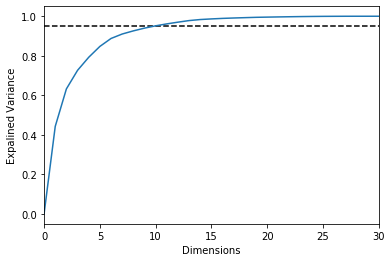

In [6]:
# Plot Explained Variance as a function of number of PCs
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum = [0]+list(cumsum)
plt.plot([x for x in range(len(cumsum))], cumsum)
plt.xlabel('Dimensions')
plt.ylabel('Expalined Variance')
plt.hlines(0.95, 0, 30, colors='k', linestyles = 'dashed')
plt.xlim(0,30)

Text(0.5, 1.0, 'Top 2 Features using PCA')

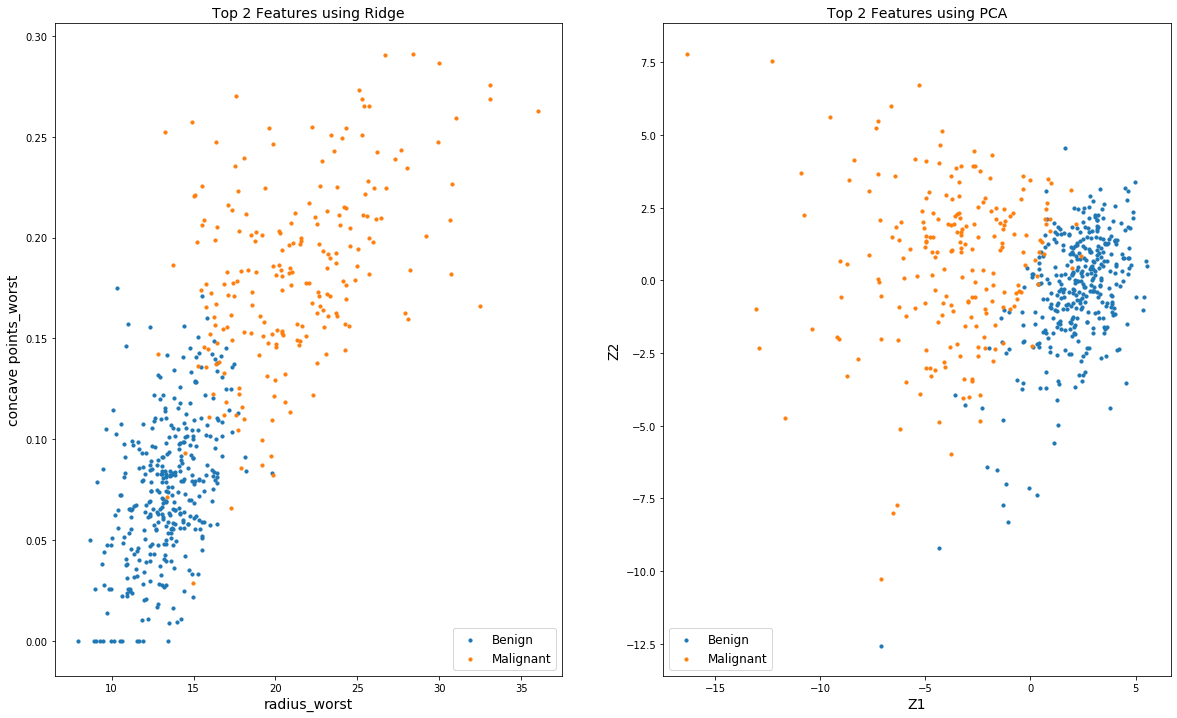

In [7]:
# Scatter Plot using top 2 ridge regression estimates
plt.rcParams['figure.figsize'] = [20, 12]
Malignant = dat[['radius_worst', 'concave points_worst']][y==1].values
Benign = dat[['radius_worst', 'concave points_worst']][y==0].values
plt.subplot(1, 2, 1)
plt.scatter(Benign[:,0], Benign[:, 1], s=10, label='Benign')
plt.scatter(Malignant[:,0], Malignant[:, 1], s=10, label='Malignant')
plt.legend(fontsize = 'large', loc = 'lower right')
plt.xlabel('radius_worst', fontsize=14)
plt.ylabel('concave points_worst', fontsize=14)
plt.title('Top 2 Features using Ridge', fontsize=14)

# Scatter Plot using top 2 Principal Components
W2 = Vt.T[:, :2]
X2D = X_std.dot(W2)
plt.subplot(1, 2, 2)
plt.scatter(X2D[:,0][y==0], X2D[:,1][y==0], s=10, label='Benign')
plt.scatter(X2D[:,0][y==1], X2D[:,1][y==1], s=10, label='Malignant')
plt.legend(fontsize = 'large', loc = 'lower left')
plt.xlabel('Z1', fontsize=14)
plt.ylabel('Z2', fontsize=14)
plt.title('Top 2 Features using PCA', fontsize=14)

In [8]:
## Split Data into Train and Test Sets

# Import Libraries
from sklearn.model_selection import train_test_split

# Separate into Training and Test Sets (All Features)
x_train, x_test, y_train, y_test  = train_test_split(X_std, y, test_size=0.2, random_state=0, stratify=y)

# Separate into Training and Test Sets (2 Features based on Ridge)
radius_worst_index = list(dat.columns[2:32]).index('radius_worst')
concave_points_worst_index = list(dat.columns[2:32]).index('concave points_worst')
x_train_2D_ridge = x_train[:, [radius_worst_index, concave_points_worst_index]]
x_test_2D_ridge = x_test[:, [radius_worst_index, concave_points_worst_index]]

# Separate into Training and Test Sets (2 Features based on PCA)
U, s, Vt = np.linalg.svd(x_train)
W2 = Vt.T[:, :2]
x_train_2D_PCA = x_train.dot(W2)
U, s, Vt = np.linalg.svd(x_test)
W2 = Vt.T[:, :2]
x_test_2D_PCA = x_test.dot(W2)

In [9]:
## KMeans Analysis

# Import Libraries
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

print('*****K Means*****')
print('*****All Feature Analysis*****')
# Training Accuracy
kmeans_clf = KMeans(n_clusters=2).fit(x_train)
labels_train = kmeans_clf.labels_
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = kmeans_clf.predict(x_test)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****Ridge Feature Selection Analysis*****')
# Training Accuracy
kmeans_clf = KMeans(n_clusters=2).fit(x_train_2D_ridge)
labels_train = kmeans_clf.labels_
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = kmeans_clf.predict(x_test_2D_ridge)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****PCA Feature Selection Analysis*****')
# Training Accuracy
kmeans_clf = KMeans(n_clusters=2).fit(x_train_2D_PCA)
labels_train = kmeans_clf.labels_
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = kmeans_clf.predict(x_test_2D_PCA)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

*****K Means*****
*****All Feature Analysis*****
Train Accuracy: 90.99%
Test Accuracy: 87.72%
*****Ridge Feature Selection Analysis*****
Train Accuracy: 93.85%
Test Accuracy: 95.61%
*****PCA Feature Selection Analysis*****
Train Accuracy: 90.77%
Test Accuracy: 93.86%


In [10]:
## K-Nearest Neighbor Analysis

# Import Libraries
from sklearn.neighbors import KNeighborsClassifier

print('*****K Nearest Neighbors*****')
print('*****All Feature Analysis*****')
# Training Accuracy
knn_clf = KNeighborsClassifier().fit(x_train, y_train)
labels_train = knn_clf.predict(x_train)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = knn_clf.predict(x_test)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****Ridge Feature Selection Analysis*****')
# Training Accuracy
knn_clf = KNeighborsClassifier().fit(x_train_2D_ridge, y_train)
labels_train = knn_clf.predict(x_train_2D_ridge)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = knn_clf.predict(x_test_2D_ridge)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****PCA Feature Selection Analysis*****')
# Training Accuracy
knn_clf = KNeighborsClassifier().fit(x_train_2D_PCA, y_train)
labels_train = knn_clf.predict(x_train_2D_PCA)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = knn_clf.predict(x_test_2D_PCA)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

*****K Nearest Neighbors*****
*****All Feature Analysis*****
Train Accuracy: 97.58%
Test Accuracy: 93.86%
*****Ridge Feature Selection Analysis*****
Train Accuracy: 95.82%
Test Accuracy: 92.11%
*****PCA Feature Selection Analysis*****
Train Accuracy: 95.82%
Test Accuracy: 82.46%


In [11]:
## Logistic Regression

# Import Libraries
from sklearn.linear_model import LogisticRegression

print('*****Logistic Regression*****')
print('*****All Feature Analysis*****')
# Training Accuracy
log_clf = LogisticRegression().fit(x_train, y_train)
labels_train = log_clf.predict(x_train)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = log_clf.predict(x_test)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****Ridge Feature Selection Analysis*****')
# Training Accuracy
log_clf = LogisticRegression().fit(x_train_2D_ridge, y_train)
labels_train = log_clf.predict(x_train_2D_ridge)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = log_clf.predict(x_test_2D_ridge)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****PCA Feature Selection Analysis*****')
# Training Accuracy
log_clf = LogisticRegression().fit(x_train_2D_PCA, y_train)
labels_train = log_clf.predict(x_train_2D_PCA)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = log_clf.predict(x_test_2D_PCA)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

*****Logistic Regression*****
*****All Feature Analysis*****
Train Accuracy: 99.34%
Test Accuracy: 97.37%
*****Ridge Feature Selection Analysis*****
Train Accuracy: 94.95%
Test Accuracy: 93.86%
*****PCA Feature Selection Analysis*****
Train Accuracy: 96.48%
Test Accuracy: 83.33%


In [12]:
## Support Vector Machine

# Import Library
from sklearn.svm import LinearSVC

print('*****Support Vector Machine*****')
print('*****All Feature Analysis*****')
# Training Accuracy
svm_clf = LinearSVC(max_iter=1000000).fit(x_train, y_train)
labels_train = svm_clf.predict(x_train)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = svm_clf.predict(x_test)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****Ridge Feature Selection Analysis*****')
# Training Accuracy
svm_clf = LinearSVC(max_iter=1000000).fit(x_train_2D_ridge, y_train)
labels_train = svm_clf.predict(x_train_2D_ridge)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = svm_clf.predict(x_test_2D_ridge)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****PCA Feature Selection Analysis*****')
# Training Accuracy
svm_clf = LinearSVC(max_iter=1000000).fit(x_train_2D_PCA, y_train)
labels_train = svm_clf.predict(x_train_2D_PCA)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = svm_clf.predict(x_test_2D_PCA)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

*****Support Vector Machine*****
*****All Feature Analysis*****
Train Accuracy: 99.12%
Test Accuracy: 96.49%
*****Ridge Feature Selection Analysis*****
Train Accuracy: 95.38%
Test Accuracy: 93.86%
*****PCA Feature Selection Analysis*****
Train Accuracy: 96.26%
Test Accuracy: 81.58%


In [13]:
## Random Forest

# Import Library
from sklearn.ensemble import RandomForestClassifier

print('*****Random Forest Classifier*****')
print('*****All Feature Analysis*****')
# Training Accuracy
RF_clf = RandomForestClassifier(max_depth =5).fit(x_train, y_train)
labels_train = RF_clf.predict(x_train)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = RF_clf.predict(x_test)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****Ridge Feature Selection Analysis*****')
# Training Accuracy
RF_clf = RandomForestClassifier(max_depth =5).fit(x_train_2D_ridge, y_train)
labels_train = RF_clf.predict(x_train_2D_ridge)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = RF_clf.predict(x_test_2D_ridge)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

print('*****PCA Feature Selection Analysis*****')
# Training Accuracy
RF_clf = RandomForestClassifier(max_depth =5).fit(x_train_2D_PCA, y_train)
labels_train = RF_clf.predict(x_train_2D_PCA)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = RF_clf.predict(x_test_2D_PCA)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

*****Random Forest Classifier*****
*****All Feature Analysis*****
Train Accuracy: 99.56%
Test Accuracy: 94.74%
*****Ridge Feature Selection Analysis*****
Train Accuracy: 97.8%
Test Accuracy: 93.86%
*****PCA Feature Selection Analysis*****
Train Accuracy: 98.02%
Test Accuracy: 85.09%


In [14]:
# Identify Optimal Hyperparameters for Full Feature Model (LR and SVM)

# Load Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

print('***Optimal Hyperparameters***')

# Logistic Regression
logistic = LogisticRegression(max_iter=1000000)
C = [0.1,1,10,100,1000,10000]
log_clf = GridSearchCV(logistic, dict(C=C), cv=5, verbose=0)
best_model = log_clf.fit(x_train, y_train)
print('Best C Parameter for Logistic: ', best_model.best_estimator_.get_params()['C'])

# Support Vector Machine
SVM = LinearSVC(max_iter=1000000)
C = [0.1,1,10,100,1000,10000]
SVM_clf = GridSearchCV(SVM, dict(C=C), cv=5, verbose=0)
best_model = SVM_clf.fit(x_train, y_train)
print('Best C Parameter for SVM: ', best_model.best_estimator_.get_params()['C'])

# Random Forest
RF = RandomForestClassifier()
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
RF_clf = GridSearchCV(RF, dict(max_depth=max_depth), cv=5, verbose=0)
best_model = RF_clf.fit(x_train, y_train)
print('Best max_depth Parameter for RF: ', best_model.best_estimator_.get_params()['max_depth'])

print('***Ensemble Results***')

# Voting Classifier
log_clf = LogisticRegression(C=1)
svm_clf = LinearSVC(C=0.1)
rf_clf = RandomForestClassifier(max_depth=80)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf), ('rf', rf_clf)],
    voting='hard')
voting_clf.fit(x_train, y_train)

# Training Accuracy
labels_train = voting_clf.predict(x_train)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = voting_clf.predict(x_test)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

***Optimal Hyperparameters***
Best C Parameter for Logistic:  1
Best C Parameter for SVM:  0.1
Best max_depth Parameter for RF:  40
***Ensemble Results***
Train Accuracy: 99.34%
Test Accuracy: 97.37%


In [15]:
# Identify Optimal Hyperparameters for Ridge Parameter Model (LR and SVM)

# Load Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

print('***Optimal Hyperparameters***')

# Logistic Regression
logistic = LogisticRegression(max_iter=1000000)
C = [0.1,1,10,100,1000,10000]
log_clf = GridSearchCV(logistic, dict(C=C), cv=5, verbose=0)
best_model = log_clf.fit(x_train_2D_ridge, y_train)
print('Best C Parameter for Logistic: ', best_model.best_estimator_.get_params()['C'])

# Random Forest
RF = RandomForestClassifier(random_state=0)
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
RF_clf = GridSearchCV(RF, dict(max_depth=max_depth), cv=5, verbose=0)
best_model = RF_clf.fit(x_train_2D_ridge, y_train)
print('Best max_depth Parameter for RF: ', best_model.best_estimator_.get_params()['max_depth'])

# KNN
KNN = KNeighborsClassifier()
Ks = [x+1 for x in range(15)]
KNN_clf = GridSearchCV(KNN, dict(n_neighbors=Ks), cv=5, verbose=0)
best_model = KNN_clf.fit(x_train_2D_ridge, y_train)
print('Best K Parameter for KNN: ', best_model.best_estimator_.get_params()['n_neighbors'])

print('***Ensemble Results***')
# Voting Classifier
log_clf = LogisticRegression(C=10)
svm_clf = LinearSVC(C=1)
rf_clf = RandomForestClassifier(max_depth=10)
knn_clf = KNeighborsClassifier(n_neighbors=9)
kmeans_clf = KMeans(n_clusters=2)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf), ('rf', rf_clf), ('knn', knn_clf)],
    voting='hard')
voting_clf.fit(x_train_2D_ridge, y_train)

# Training Accuracy
labels_train = voting_clf.predict(x_train_2D_ridge)
accuracy1 = accuracy_score(y_train, labels_train)
accuracy2 = accuracy_score(y_train, np.where(labels_train==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Train Accuracy: ' + str(round(accuracy*100,2)) + '%')

# Testing Accuracy
labels_test = voting_clf.predict(x_test_2D_ridge)
accuracy1 = accuracy_score(y_test, labels_test)
accuracy2 = accuracy_score(y_test, np.where(labels_test==1,0,1))
if accuracy1>accuracy2:
    accuracy = accuracy1
else:
    accuracy = accuracy2
print('Test Accuracy: ' + str(round(accuracy*100,2)) + '%')

***Optimal Hyperparameters***
Best C Parameter for Logistic:  10
Best max_depth Parameter for RF:  10
Best K Parameter for KNN:  9
***Ensemble Results***
Train Accuracy: 96.26%
Test Accuracy: 93.86%


In [16]:
# Generate Classification Boundary

# All Features
#log_clf = LogisticRegression(C=1).fit(x_train, y_train)
#probabilities = log_clf.predict_proba(x_train)[:,1]

# Ridge Features
log_clf = LogisticRegression(C=10).fit(x_train_2D_ridge, y_train)
probabilities = log_clf.predict_proba(x_train_2D_ridge)[:,1]

# Generate Confusion Matrix Statistics at different probability thresholds
classification_results = pd.DataFrame(columns=['Threshold Probability', 'Accuracy', 'NPV', 'TPV'])
probs = [x/100 for x in range(1, 100, 1)]
iterator = 0
for p in probs:
    predictions = np.where(probabilities<=p, 0, 1)
    # Generate Initial TPs, FPs, etc.
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_train)): 
        if predictions[i]==y_train[i]==1:
            TP += 1
        if predictions[i]==1 and y_train[i]!=predictions[i]:
            FP += 1
        if predictions[i]==y_train[i]==0:
            TN += 1
        if predictions[i]==0 and y_train[i]!=predictions[i]:
            FN += 1
    
    # Store Sensitivity and Specificity Metrics
    classification_results.loc[iterator, ['Threshold Probability']] = p
    classification_results.loc[iterator, ['Accuracy']] = (TP+TN)/(TP+TN+FP+FN)
    if((TN+FN) > 0):
        classification_results.loc[iterator, ['NPV']] = TN/(TN + FN)
    else:
        classification_results.loc[iterator, ['NPV']] = 0   
    if((TP+FP) > 0):
        classification_results.loc[iterator, ['TPV']] = TP/(TP + FP)
    else:
        classification_results.loc[iterator, ['TPV']] = 0
        
    iterator += 1

# Save Indices
indices_Accucacy = np.where(classification_results['Accuracy']==np.max(classification_results['Accuracy']))[0]
indices_NPV = np.where(classification_results['NPV']>=0.99)[0]
best_p_accuracy = classification_results.iloc[indices_Accucacy, 0].values[0]
best_p_NPV = classification_results.iloc[indices_NPV, 0].values[len(indices_NPV)-1]

# Print Out Accuracy, TPV, and NPV at best thresholds
print('***Training Results***')
print('***Best Accuracy***')
print('Probability for Best Accuracy: ' + str(best_p_accuracy))
print('Accuracy: ' + str(round(classification_results.iloc[indices_Accucacy, 1].values[0]*100,2))+'%')
print('NPV: ' + str(round(classification_results.iloc[indices_Accucacy, 2].values[0]*100,2))+'%')
print('TPV: ' + str(round(classification_results.iloc[indices_Accucacy, 3].values[0]*100,2))+'%')
print('***Best NPV***')
print('Probability for Best NPV: ' + str(best_p_NPV))
print('Accuracy: ' + str(round(classification_results.iloc[indices_NPV, 1].values[len(indices_NPV)-1]*100,2))+'%')
print('NPV: ' + str(round(classification_results.iloc[indices_NPV, 2].values[len(indices_NPV)-1]*100,2))+'%')
print('TPV: ' + str(round(classification_results.iloc[indices_NPV, 3].values[len(indices_NPV)-1]*100,2))+'%')

***Training Results***
***Best Accuracy***
Probability for Best Accuracy: 0.4
Accuracy: 95.38%
NPV: 97.48%
TPV: 92.09%
***Best NPV***
Probability for Best NPV: 0.07
Accuracy: 89.67%
NPV: 99.17%
TPV: 78.87%


In [17]:
# Print Out Test Results Using these metrics

# Best Accuracy Results

# All Features
x = x_test_2D_ridge
probabilities = log_clf.predict_proba(x)[:,1]

# Create Predictions
predictions = np.where(probabilities<=best_p_accuracy, 0, 1)

TP = 0
FP = 0
TN = 0
FN = 0
    
for i in range(len(y_test)): 
    if predictions[i]==y_test[i]==1:
        TP += 1
    if predictions[i]==1 and y_test[i]!=predictions[i]:
        FP += 1
    if predictions[i]==y_test[i]==0:
        TN += 1
    if predictions[i]==0 and y_test[i]!=predictions[i]:
        FN += 1

print('***Test Results***')
print('***Accuracy Results***')
accuracy = (TP+TN)/(TP+TN+FP+FN)
npv = TN/(TN + FN)
tpv = TP/(TP + FP)
print('Accuracy: ' + str(round(accuracy*100,2)) + '%')
print('NPV: ' + str(round(npv*100,2)) + '%')
print('TPV: ' + str(round(tpv*100,2)) + '%')

# Best NPV Results
predictions = np.where(probabilities<=best_p_NPV, 0, 1)

TP = 0
FP = 0
TN = 0
FN = 0
    
for i in range(len(y_test)): 
    if predictions[i]==y_test[i]==1:
        TP += 1
    if predictions[i]==1 and y_test[i]!=predictions[i]:
        FP += 1
    if predictions[i]==y_test[i]==0:
        TN += 1
    if predictions[i]==0 and y_test[i]!=predictions[i]:
        FN += 1
        
print('***NPV Results***')
accuracy = (TP+TN)/(TP+TN+FP+FN)
npv = TN/(TN + FN)
tpv = TP/(TP + FP)
print('Accuracy: ' + str(round(accuracy*100,2)) + '%')
print('NPV: ' + str(round(npv*100,2)) + '%')
print('TPV: ' + str(round(tpv*100,2)) + '%')

***Test Results***
***Accuracy Results***
Accuracy: 92.11%
NPV: 95.65%
TPV: 86.67%
***NPV Results***
Accuracy: 84.21%
NPV: 98.21%
TPV: 70.69%


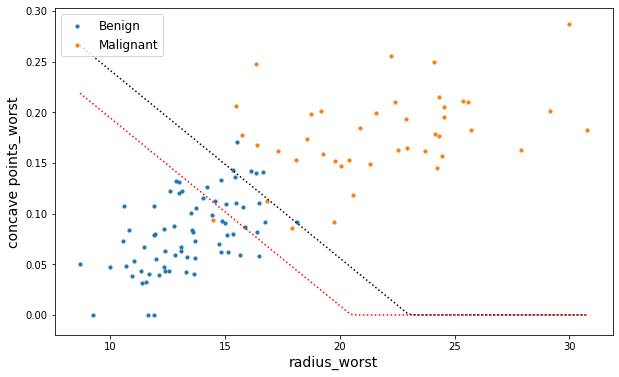

In [19]:
# Decision Boundary Plot
x_min = np.min(x_test_2D_ridge[:,0])
x_max = np.max(x_test_2D_ridge[:,0])
y_min = np.min(x_test_2D_ridge[:,1])
y_max = np.max(x_test_2D_ridge[:,1])

# Generate decision line for best accuracy
results_accuracy = []
x_vals = np.linspace(x_min,x_max,114)
for x_val in x_vals:
    for y_val in np.linspace(y_min,y_max,1000):
        predict_prob = log_clf.predict_proba(np.array([x_val,y_val]).reshape(1, -1))[:,1][0]
        if predict_prob > best_p_accuracy:
            results_accuracy.append(y_val)
            break

# Generate decision line for best NPV
results_NPV = []
for x_val in x_vals:
    for y_val in np.linspace(y_min,y_max,1000):
        predict_prob = log_clf.predict_proba(np.array([x_val,y_val]).reshape(1, -1))[:,1][0]
        if predict_prob > best_p_NPV:
            results_NPV.append(y_val)
            break
            
# Scale Back
scaler = StandardScaler()
X_std2D = scaler.fit_transform(X[:, [radius_worst_index, concave_points_worst_index]])
line_accuracy = scaler.inverse_transform(np.column_stack((x_vals, results_accuracy)))
line_NPV = scaler.inverse_transform(np.column_stack((x_vals, results_NPV)))

# Plot
plt.rcParams['figure.figsize'] = [10, 6]
Malignant = scaler.inverse_transform(x_test_2D_ridge[y_test==1])
Benign = scaler.inverse_transform(x_test_2D_ridge[y_test==0])
plt.scatter(Benign[:,0], Benign[:, 1], s=10, label='Benign')
plt.scatter(Malignant[:,0], Malignant[:, 1], s=10, label='Malignant')
plt.legend(fontsize = 'large', loc = 'upper left')
plt.xlabel('radius_worst', fontsize=14)
plt.ylabel('concave points_worst', fontsize=14)
plt.plot(line_accuracy[:, 0], line_accuracy[:, 1], "k:")
plt.plot(line_NPV[:, 0], line_NPV[:, 1], "r:")